In [1]:
import earthaccess
import rioxarray
import rasterio
import xarray as xr
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
results = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    #temporal=("2020-01-01", "2021-12-31"), # 2 years, ~ 500 GB
    temporal=("2019-01-01", "2019-01-31"),
)


Granules found: 31


## Using fsspec virtual filesystem

Rather than tediously downloading the entirety of each file and then manually looping over each one to open, read, and concatinate as shown in the [Coiled Demo](https://medium.com/coiled-hq/processing-terabyte-scale-nasa-cloud-datasets-with-coiled-70ab552f35ec), we can simply open the whole set in one go.  This lazy read method allows us to then range-request only the subset of data we need from each file, thanks to `earthaccess` using a cloud-native reads over http via the python `fsspec` package.  We can then issue the usual xarray operations to process and plot the data, treating the remote source as if it were already sitting on our local disk.  This approach is quite fast, works from any machine, and does not require spending money on AWS. (note that `fsspec` package, which is doing the core magic of allowing us to treat the remote filesystem as if it were a local filesystem, is not explicitly visible in this workflow, but earthaccess has taken care of it for us). 

In [3]:
%%time
files = earthaccess.open(results)
ds = xr.open_mfdataset(files,
                       decode_times=False, 
                       data_vars=['analysed_sst', 'sea_ice_fraction'], 
                       concat_dim="time", 
                       combine="nested",
                       parallel=True)


Opening 31 granules, approx size: 11.63 GB


QUEUEING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/31 [00:00<?, ?it/s]

CPU times: user 5.48 s, sys: 1.82 s, total: 7.3 s
Wall time: 1min 10s


In [4]:
%%time
dds = ds.sel(lon=slice(-93, -76), lat=slice(41, 49))
cond = (dds.sea_ice_fraction < 0.15) | np.isnan(dds.sea_ice_fraction)
result = dds.analysed_sst.where(cond)

CPU times: user 19.6 ms, sys: 0 ns, total: 19.6 ms
Wall time: 17.9 ms


CPU times: user 8.95 s, sys: 4.1 s, total: 13 s
Wall time: 1min 38s


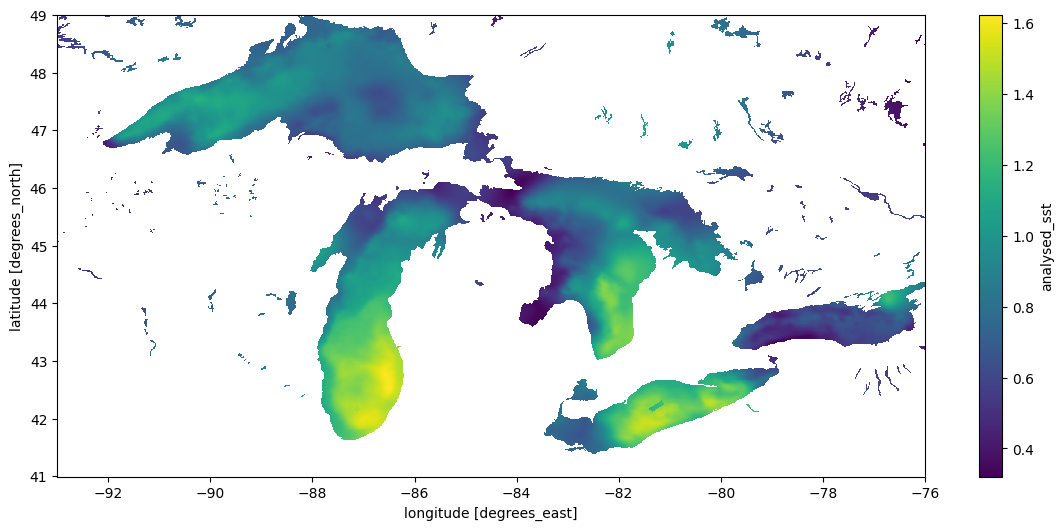

In [5]:
%%time
result.std("time").plot(figsize=(14, 6), x="lon", y="lat")

## Using GDAL Virtual Filesystem

A different virtual filesystem approach is available through GDAL. While fsspec tries to provide a generic POSIX-like interface to remote files, the GDAL VSI is specifically optimized for spatial data and often considerably faster.  The `rioxarray` package provides a drop-in engine to `xarray`'s `open_mfdataset` that uses GDAL. (Aside -- at least some of the other netcdf engines supported by xarray should also be able to natively perform range requests over URLs to data without needing the fsspec layer added by earthaccess, and may have better performance.  This case is not illustrated in this notebook). Here we'll use the GDAL VSI. 

Because the NASA EarthData are behind a security layer, using the URLs directly instead of `earthaccess` with fsspec requires a little extra handling of authentication process to make GDAL aware of the NETRC and cookie files it needs.  We'll also set some of the optional but recommended options for GDAL when using the virtual filesystem. Unfortunately this makes our code look a bit verbose -- ideally packages like `rioxarray` would take care of these things.


In [6]:
%%time
import os
from pathlib import Path
cookies = os.path.expanduser("~/.urs_cookies")
Path(cookies).touch()

## pull out the URLs
data_links = [granule.data_links(access="external") for granule in results]
url_links = [f'{link[0]}' for link in data_links]


# and here we go
with rasterio.Env(GDAL_INGESTED_BYTES_AT_OPEN="32000",
                  GDAL_HTTP_MULTIPLEX="YES",
                  GDAL_HTTP_MERGE_CONSECUTIVE_RANGES="YES",
                  GDAL_HTTP_VERSION="2",
                  GDAL_NUM_THREADS="ALL_CPUS",
                  GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
                  GDAL_HTTP_COOKIEFILE=cookies, 
                  GDAL_HTTP_COOKIEJAR=cookies, 
                  GDAL_HTTP_NETRC=True):
    ds1 = xr.open_mfdataset(url_links, 
                           engine = "rasterio", 
                           concat_dim="time", 
                           combine="nested",
                           )

CPU times: user 1.78 s, sys: 260 ms, total: 2.04 s
Wall time: 58.1 s


CPU times: user 7.39 s, sys: 2.59 s, total: 9.98 s
Wall time: 42.3 s


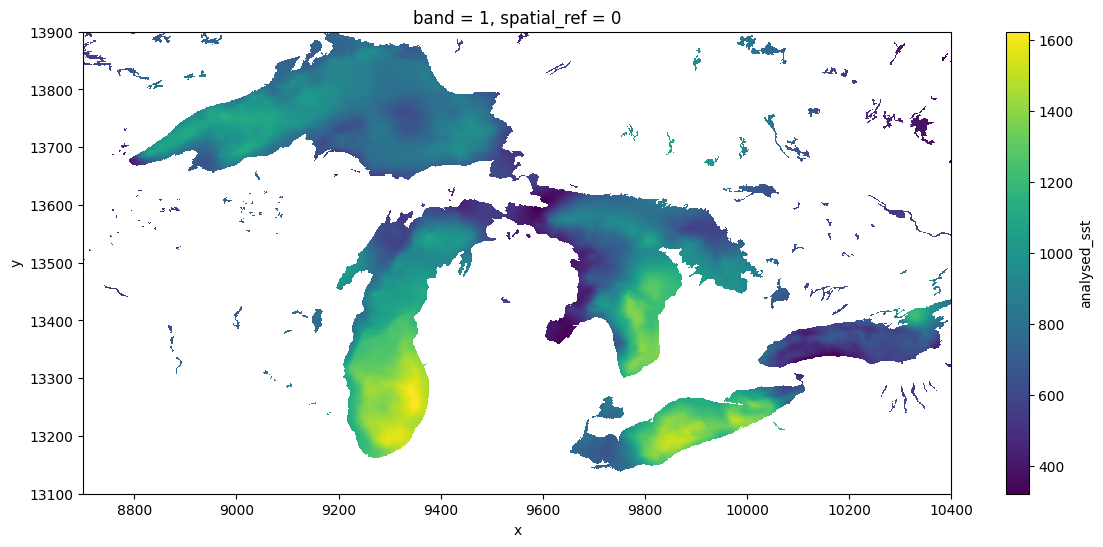

In [7]:
%%time
dds = ds1.sel(x=slice(18000-9300, 18000-7600), y = slice(9000+4100,9000+4900))
dds.analysed_sst.std("time").plot(figsize=(14, 6), x="x", y="y")



## Comparisons


The GDAL VSI is already widely used under the hood by python packages working with cloud-optimized geotiff (COG) files (e.g. via `odc.stac`, which like the above approach also produces dask-backed xarrays), and also widely used by most other languages (e.g. R) for working with any spatial data.  To GDAL, netcdf and other so-called "n-dimensional array" formats like h5, zarr are just a handful of the [160-odd formats of "raster" data](https://gdal.org/drivers/raster/index.html) it supports, along with formats like COG and GeoTIFF files.  It can be particularly powerful in more complicated workflows which require spatially-aware operations such as reprojection and aggregation.  The GDAL VSI can sometimes be considerably faster than fsspec, expecially when configured for cloud-native access.  The nusiance of these environmental variables aside, it can also be considerably easier to use and to generalize patterns across data formats (netcdf, zarr, COG), and across languages (R, C++, javascript, julia etc), since GDAL understands [all these formats] and is used in all of these languages, as well as in platforms such as Google Earth Engine and QGIS. This makes it a natural bridge between languages. This broad use over decades has made GDAL very powerful, and it continues to improve rapidly with frequent releases.  


For some reason, the `xarray` community seems to prefer to access ncdf without GDAL, whether by relying on downloading complete files, using fsspec, or other dedicated libraries (zarr). There are possibly many reasons for this. One is a divide between the the "Geospatial Information Systems" community, that thinks of file serializations as "rasters" or "vectors", and the "modeler" community, which thinks of data as "n-dimensional arrays". Both have their weaknesses and the lines are frequently blurred, but one obvious manifestation is in how each one writes their netcdf files (and how much they rely on GDAL).  For instance, this NASA product, strongly centered in the modeler community is sometimes sloppy about these metadata conventions, and as a result GDAL (especially older versions), might not detect all the details appropriately.  Note that GDAL has failed to recognize the units of lat-long, so we have had to subset the x-y positions manually.  
